<a href="https://colab.research.google.com/github/Dhanushranga1/Diffusion-AIW3/blob/main/Denoising_Model_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Step 1: Installing the libraries

In [71]:
!pip install torch torchvision --quiet
!pip install scikit-image --quiet
!pip install --quiet diffusers transformers accelerate ftfy
!pip install --quiet piq

Step 2: Importing libraries

In [81]:

import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import random
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim


seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')


Using device: cuda


Step 2: Loading the dataset

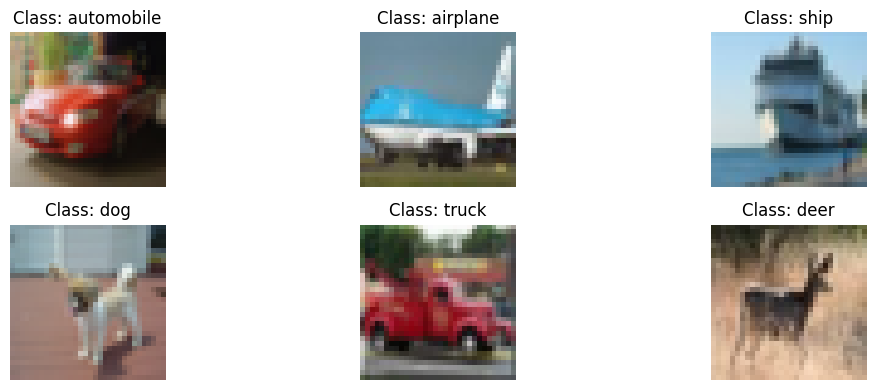

In [80]:


transform = transforms.Compose([
    transforms.ToTensor(),
])

# loading the cifar10 dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2, pin_memory=True)


images, labels = next(iter(train_loader))

# visualizing the dataset
plt.figure(figsize=(12, 4))
for i in range(6):
    img = images[i].permute(1, 2, 0).numpy()
    plt.subplot(2, 3, i + 1)
    plt.imshow(img)
    plt.title(f"Class: {train_dataset.classes[labels[i]]}")
    plt.axis("off")
plt.tight_layout()
plt.show()


Step 4: Adding the Noise

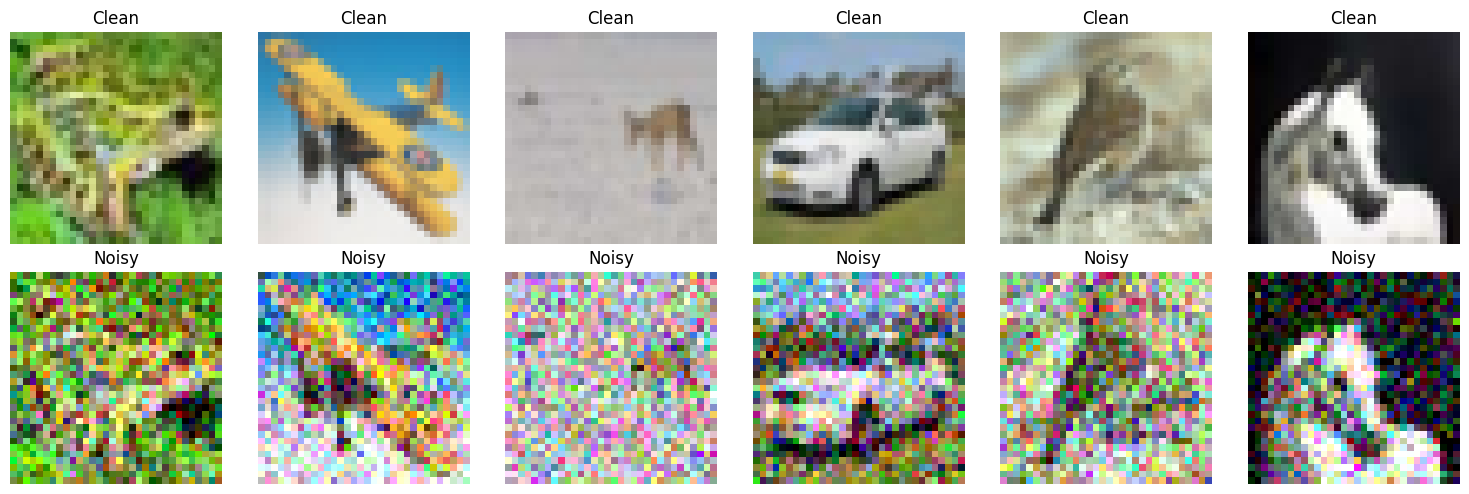

In [74]:


def add_noise(images, noise_level=0.1):

    noise = torch.randn_like(images) * noise_level
    noisy_images = images + noise
    return torch.clamp(noisy_images, 0, 1)


noisy_images = add_noise(images, noise_level=0.2)

plt.figure(figsize=(15, 5))
for i in range(6):
#clean image
    clean = images[i].permute(1, 2, 0).numpy()
    plt.subplot(2, 6, i + 1)
    plt.imshow(clean)
    plt.title("Clean")
    plt.axis("off")

#noise image
    noisy = noisy_images[i].permute(1, 2, 0).numpy()
    plt.subplot(2, 6, i + 7)
    plt.imshow(noisy)
    plt.title("Noisy")
    plt.axis("off")
plt.tight_layout()
plt.show()

Step 5: Unet Model defining

In [75]:

# Cell 5: SIMPLIFIED U-Net Model
class SimpleDenoiseUNet(nn.Module):
    def __init__(self, in_channels=3):
        super().__init__()

        # encoder
        self.enc1 = nn.Sequential(
            nn.Conv2d(in_channels, 64, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU()
        )

        self.enc2 = nn.Sequential(
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.ReLU()
        )

        # bottleneck
        self.bottleneck = nn.Sequential(
            nn.MaxPool2d(2),
            nn.Conv2d(128, 256, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.ReLU()
        )

        # decoder
        self.dec2 = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 2, stride=2),
            nn.Conv2d(256, 128, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.ReLU()
        )

        self.dec1 = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 2, stride=2),
            nn.Conv2d(128, 64, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU()
        )

        self.final = nn.Sequential(
            nn.Conv2d(64, in_channels, 1),
            nn.Sigmoid()
        )

    def forward(self, x):

        e1 = self.enc1(x)
        e2 = self.enc2(e1)


        b = self.bottleneck(e2)

        d2 = self.dec2[0](b)
        d2 = torch.cat([d2, e2], dim=1)  # skip connection
        d2 = self.dec2[1:](d2)

        d1 = self.dec1[0](d2)
        d1 = torch.cat([d1, e1], dim=1)  # skip connection
        d1 = self.dec1[1:](d1)

        return self.final(d1)

# initializing the model
model = SimpleDenoiseUNet(in_channels=3).to(device)
print(f'Model parameters: {sum(p.numel() for p in model.parameters()):,}')


Model parameters: 1,862,979


Step 6: Defining the Training Function

In [84]:
def train_simple_denoising(model, dataloader, epochs=20, noise_level=0.2):
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.MSELoss()

    for epoch in range(epochs):
        epoch_loss = 0
        pbar = tqdm(dataloader, desc=f'Epoch {epoch+1}/{epochs}')

        for batch_idx, (clean_images, _) in enumerate(pbar):
            clean_images = clean_images.to(device)

            # adding noise
            noisy_images = add_noise(clean_images, noise_level)

            # forward pass
            denoised_images = model(noisy_images)
            loss = criterion(denoised_images, clean_images)

            # backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            pbar.set_postfix({'Loss': f'{loss.item():.4f}'})

        avg_loss = epoch_loss / len(dataloader)
        print(f'Epoch {epoch+1} completed. Average Loss: {avg_loss:.4f}')

# training the model

train_simple_denoising(model, train_loader, epochs=15, noise_level=0.2)


Epoch 1/15: 100%|██████████| 1563/1563 [00:31<00:00, 49.99it/s, Loss=0.0032]


Epoch 1 completed. Average Loss: 0.0032


Epoch 2/15: 100%|██████████| 1563/1563 [00:31<00:00, 50.17it/s, Loss=0.0032]


Epoch 2 completed. Average Loss: 0.0031


Epoch 3/15: 100%|██████████| 1563/1563 [00:31<00:00, 49.55it/s, Loss=0.0031]


Epoch 3 completed. Average Loss: 0.0031


Epoch 4/15: 100%|██████████| 1563/1563 [00:30<00:00, 51.00it/s, Loss=0.0032]


Epoch 4 completed. Average Loss: 0.0031


Epoch 5/15: 100%|██████████| 1563/1563 [00:30<00:00, 50.71it/s, Loss=0.0031]


Epoch 5 completed. Average Loss: 0.0031


Epoch 6/15: 100%|██████████| 1563/1563 [00:30<00:00, 51.56it/s, Loss=0.0036]


Epoch 6 completed. Average Loss: 0.0031


Epoch 7/15: 100%|██████████| 1563/1563 [00:30<00:00, 50.53it/s, Loss=0.0030]


Epoch 7 completed. Average Loss: 0.0031


Epoch 8/15: 100%|██████████| 1563/1563 [00:30<00:00, 51.41it/s, Loss=0.0029]


Epoch 8 completed. Average Loss: 0.0031


Epoch 9/15: 100%|██████████| 1563/1563 [00:30<00:00, 50.76it/s, Loss=0.0029]


Epoch 9 completed. Average Loss: 0.0031


Epoch 10/15: 100%|██████████| 1563/1563 [00:30<00:00, 51.63it/s, Loss=0.0033]


Epoch 10 completed. Average Loss: 0.0031


Epoch 11/15: 100%|██████████| 1563/1563 [00:30<00:00, 50.67it/s, Loss=0.0034]


Epoch 11 completed. Average Loss: 0.0031


Epoch 12/15: 100%|██████████| 1563/1563 [00:30<00:00, 51.63it/s, Loss=0.0034]


Epoch 12 completed. Average Loss: 0.0031


Epoch 13/15: 100%|██████████| 1563/1563 [00:31<00:00, 50.39it/s, Loss=0.0026]


Epoch 13 completed. Average Loss: 0.0031


Epoch 14/15: 100%|██████████| 1563/1563 [00:30<00:00, 51.08it/s, Loss=0.0032]


Epoch 14 completed. Average Loss: 0.0031


Epoch 15/15: 100%|██████████| 1563/1563 [00:31<00:00, 50.32it/s, Loss=0.0027]

Epoch 15 completed. Average Loss: 0.0031


Step 7: Evalutation and Metrics

In [85]:

def calculate_metrics(clean_img, denoised_img):
    if torch.is_tensor(clean_img):
        clean_np = clean_img.cpu().numpy()
    else:
        clean_np = clean_img

    if torch.is_tensor(denoised_img):
        denoised_np = denoised_img.cpu().numpy()
    else:
        denoised_np = denoised_img

    if clean_np.shape[0] == 3:
        clean_np = clean_np.transpose(1, 2, 0)
        denoised_np = denoised_np.transpose(1, 2, 0)

    clean_np = np.clip(clean_np, 0, 1)
    denoised_np = np.clip(denoised_np, 0, 1)

    # PSNR
    psnr_value = psnr(clean_np, denoised_np, data_range=1.0)

    # SSIM
    ssim_value = ssim(clean_np, denoised_np, data_range=1.0, channel_axis=2)

    return psnr_value, ssim_value

# Test the model
model.eval()
test_samples = 10
psnr_scores = []
ssim_scores = []
psnr_noisy_scores = []
ssim_noisy_scores = []

print("Evaluating model performance...")
with torch.no_grad():
    for i in range(test_samples):
        clean_img = images[i].to(device)
        noisy_img = add_noise(clean_img.unsqueeze(0), noise_level=0.2)


        denoised_img = model(noisy_img).squeeze(0)


        psnr_val, ssim_val = calculate_metrics(clean_img, denoised_img)
        psnr_scores.append(psnr_val)
        ssim_scores.append(ssim_val)


        psnr_noisy, ssim_noisy = calculate_metrics(clean_img, noisy_img.squeeze(0))
        psnr_noisy_scores.append(psnr_noisy)
        ssim_noisy_scores.append(ssim_noisy)

print("\n=== RESULTS ===")
print(f'Noisy Images - Average PSNR: {np.mean(psnr_noisy_scores):.2f} dB, SSIM: {np.mean(ssim_noisy_scores):.3f}')
print(f'Denoised Images - Average PSNR: {np.mean(psnr_scores):.2f} dB, SSIM: {np.mean(ssim_scores):.3f}')
print(f'Improvement - PSNR: +{np.mean(psnr_scores) - np.mean(psnr_noisy_scores):.2f} dB, SSIM: +{np.mean(ssim_scores) - np.mean(ssim_noisy_scores):.3f}')


Evaluating model performance...

=== RESULTS ===
Noisy Images - Average PSNR: 14.64 dB, SSIM: 0.400
Denoised Images - Average PSNR: 25.11 dB, SSIM: 0.840
Improvement - PSNR: +10.47 dB, SSIM: +0.441


Step 8: Visualising if our model is working the correct way


Visualizing results...


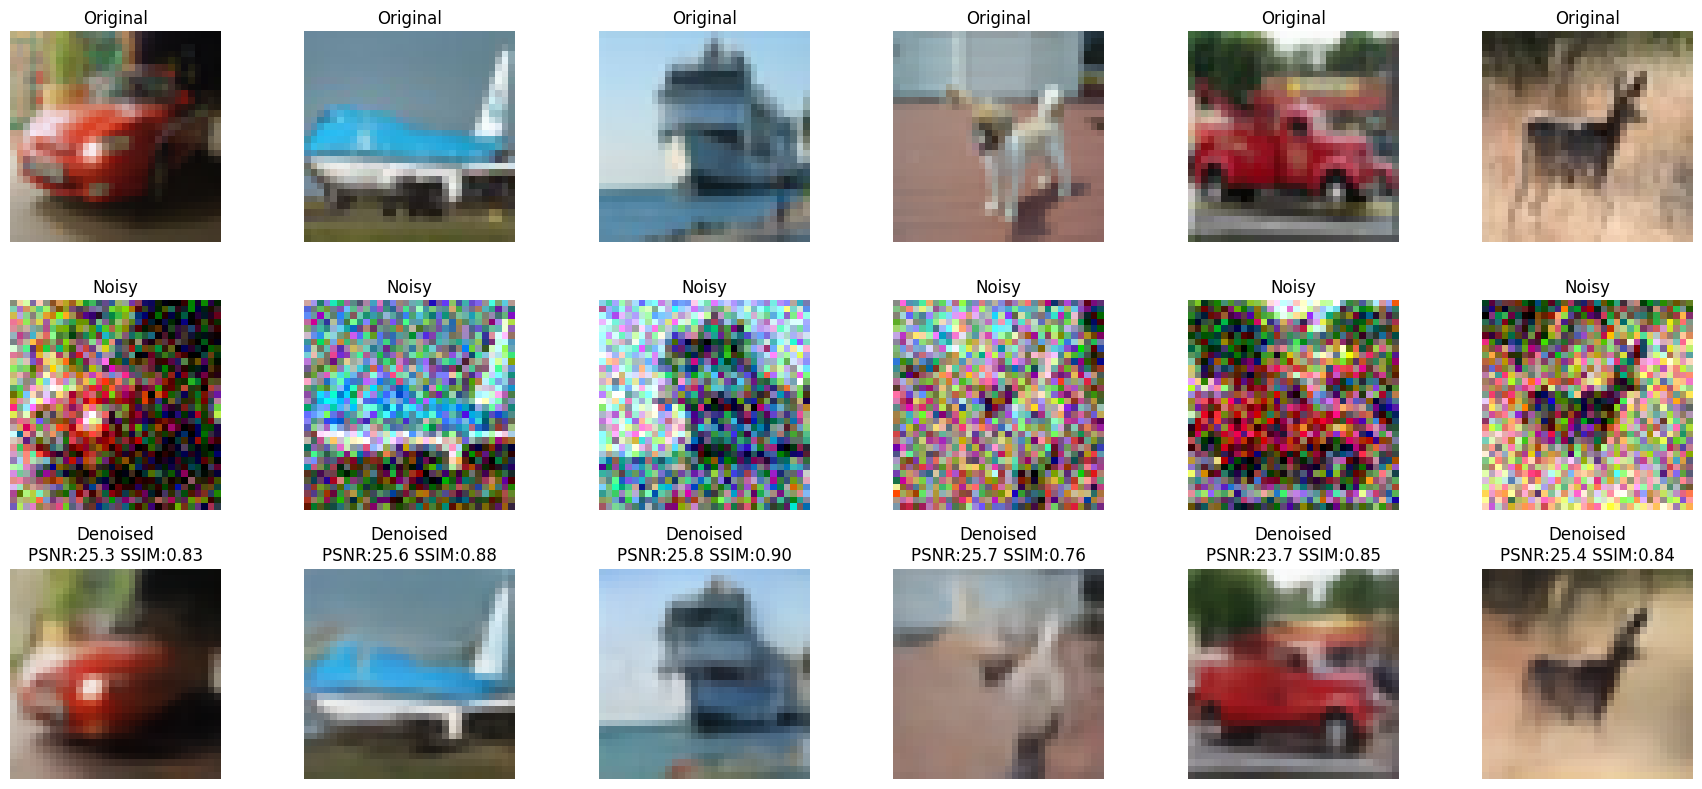

In [86]:

# Cell 8: Visualization
def show_results(num_samples=6):
    model.eval()
    fig, axes = plt.subplots(3, num_samples, figsize=(18, 8))

    with torch.no_grad():
        for i in range(num_samples):
            clean_img = images[i].to(device)
            noisy_img = add_noise(clean_img.unsqueeze(0), noise_level=0.2)
            denoised_img = model(noisy_img).squeeze(0)

            # Convert to displayable format
            clean_display = clean_img.cpu().permute(1, 2, 0).numpy()
            noisy_display = noisy_img.squeeze(0).cpu().permute(1, 2, 0).numpy()
            denoised_display = denoised_img.cpu().permute(1, 2, 0).numpy()

            # Clip values to [0,1]
            clean_display = np.clip(clean_display, 0, 1)
            noisy_display = np.clip(noisy_display, 0, 1)
            denoised_display = np.clip(denoised_display, 0, 1)

            # Calculate metrics for this sample
            psnr_val, ssim_val = calculate_metrics(clean_display, denoised_display)

            axes[0, i].imshow(clean_display)
            axes[0, i].set_title('Original')
            axes[0, i].axis('off')

            axes[1, i].imshow(noisy_display)
            axes[1, i].set_title('Noisy')
            axes[1, i].axis('off')

            axes[2, i].imshow(denoised_display)
            axes[2, i].set_title(f'Denoised\nPSNR:{psnr_val:.1f} SSIM:{ssim_val:.2f}')
            axes[2, i].axis('off')

    plt.tight_layout()
    plt.show()

print("\nVisualizing results...")
show_results()

Step 9: Saving the Model

In [87]:

torch.save(model.state_dict(), 'simple_denoising_model.pth')
print('Model saved as simple_denoising_model.pth')


Model saved as simple_denoising_model.pth
